In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import serial
import time

In [ ]:
# Defining the serial COM
SerialObj = serial.Serial('COM3')

SerialObj.baudrate = 115200
SerialObj.bytesize = 8
time.sleep(3)

In [2]:
# Defining constants
NUM_CLASS = 2
IMAGE_SIZE = (224, 224)  # ResNet50 input size
BATCH_SIZE = 32

In [3]:
# Load training data
def load_data(path):
    images = []
    labels = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.resize(img, IMAGE_SIZE)  # Resize images to ResNet50 input size
        images.append(img)
        labels.append(path.split('/')[-1])  # Assuming the label is the name of the directory
    return images, labels

def test_image(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMAGE_SIZE)  # Resize image to match training data size
    img = preprocess_input(img)  # Preprocess the image for ResNet50
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    if np.argmax(prediction) == 0:
        print("Detected object: Apple")
    else:
        print("Detected object: Banana")

In [4]:
# Paths for the training data
apple_path = "C:/Users/zuzz4/OneDrive/Desktop/data new/train/Apple"
banana_path = "C:/Users/zuzz4/OneDrive/Desktop/data new/train/Banana"
test_path = "C:/Users/zuzz4/OneDrive/Desktop/data new/Test"

In [5]:
# Load training data
apple_images, apple_labels = load_data(apple_path)
banana_images, banana_labels = load_data(banana_path)

# Combine data and labels
images = np.array(apple_images + banana_images)
labels = np.array(apple_labels + banana_labels)

# Convert labels to one-hot encoding
label_dict = {'Apple': 0, 'Banana': 1}
labels = np.array([label_dict[label] for label in labels])

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load ResNet50 model pretrained on ImageNet without the top classification layer
base_model = ResNet50(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze the pretrained layers
base_model.trainable = False

In [7]:
# The model and custom classfication head
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

In [8]:
# Chossing the optimizer and complining the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# Saving the best model based on validation accuracy
checkpoint = ModelCheckpoint("transfer_learning_resnet_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Print test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


Epoch 1/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6327 - loss: 12.0183
Epoch 1: val_accuracy improved from -inf to 0.97561, saving model to transfer_learning_resnet_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6455 - loss: 12.0692 - val_accuracy: 0.9756 - val_loss: 0.6502
Epoch 2/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9816 - loss: 0.2917
Epoch 2: val_accuracy improved from 0.97561 to 1.00000, saving model to transfer_learning_resnet_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9816 - loss: 0.3201 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9871 - loss: 0.0140
Epoch 3: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9880 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/35
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 1.6925e-07
Epoch 4: val_accuracy did not improve from 1.00000
6/6 ━━━

In [ ]:
# Camera Code to capture the photo for testing
import cv2
import os
import time

def capture_and_save_image(folder_path):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Open the default camera (usually 0)
    cap = cv2.VideoCapture(0)

    # Check if the camera is opened successfully
    if not cap.isOpened():
        print("Error: Unable to open camera")
        return

    # Allow the camera to adjust to the lighting conditions (1-second delay)
    time.sleep(1)

    # Capture frame-by-frame
    ret, frame = cap.read()

    # Display the captured frame
    cv2.imshow('Captured Image', frame)
    
    # Save the image to the specified folder path
    image_path = os.path.join(folder_path, 'captured_image.jpg')
    cv2.imwrite(image_path, frame)
    
    print("Image saved successfully at:", image_path)

    # Release the camera and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

# Specify the folder path where the image will be saved
folder_path = r"C:/Users/zuzz4/OneDrive/Desktop/data new/Test"

# Call the function to capture and save the image
capture_and_save_image(folder_path)


In [ ]:
# Load test images
test_images = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels=None,
    color_mode='rgb',
    label_mode=None,
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

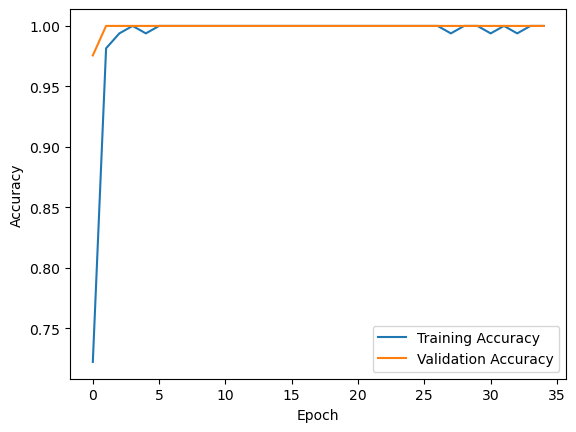

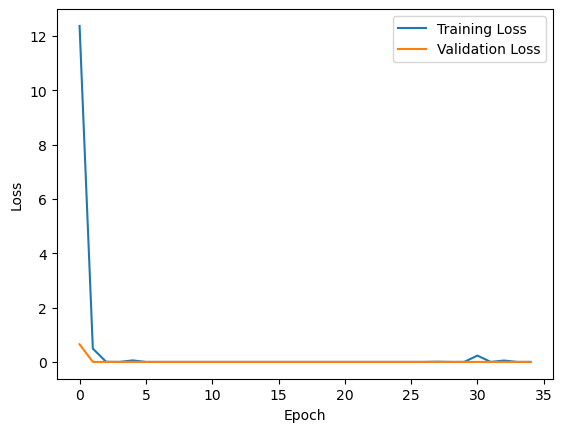

In [11]:
# Plotting Cell
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Make predictions on test images
print("\nPredictions on test images:")
for images in test_images:
    result = model.predict(images)
    print(result)
    break  # Only print predictions for the first batch



Predictions on test images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0. 1.]]


In [ ]:
# Control for the ServoMotors
if (result[0][0] >= 0.7) and  (result[0][1] <= 0.5) :
    SerialObj.write(b'1')
elif (result[0][1] >= 0.7) and  (result[0][0] <= 0.5):
    SerialObj.write(b'2')
       